# ParSNIP model demonstration

This notebook probes the ParSNIP model and latent representation including:
* Showing examples of ParSNIP light curve models.
* Measuring how well the ParSNIP model is able to reconstruct out-of-sample light curves.
* Plotting the ParSNIP representations and examining where different types of objects are found.
* Comparing ParSNIP with SALT2.
* Showing the ParSNIP Hubble Diagram

# Load the datasets and models

In [1]:
# Import required packages
from astropy.table import Table, join
from astropy.cosmology import Planck18 as cosmo
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from scipy.optimize import minimize
from scipy.special import erfc

import numpy as np
import matplotlib.colors as colors
import sncosmo
import lcdata

import parsnip

In [2]:
%%time
# Load the PS1 dataset and model.

# Load the PS1 dataset
ps1_dataset_raw = parsnip.load_dataset('../data/ps1.h5')

# Load the models
ps1_model = parsnip.load_model('../models/parsnip_ps1.pt')
ps1_validation_model = parsnip.load_model('../models/parsnip_ps1_validation.pt')

# Preprocess the dataset
ps1_dataset = ps1_model.preprocess(ps1_dataset_raw)

# Split into train/test
ps1_train, ps1_test = parsnip.split_train_test(ps1_dataset)

Parsing 'ps1.h5' as PanSTARRS dataset ...
Preprocessing dataset: 100%|██████████| 2885/2885 [00:02<00:00, 1248.62it/s]
CPU times: user 4.27 s, sys: 315 ms, total: 4.58 s
Wall time: 3.43 s


In [3]:
%%time
# Load the PLAsTiCC dataset and model.

# Load the combined PLAsTiCC dataset that was used for training
plasticc_dataset_raw = parsnip.load_dataset('../data/plasticc_combined.h5')

# Load the PLAsTiCC models
plasticc_model = parsnip.load_model('../models/parsnip_plasticc.pt')
plasticc_validation_model = parsnip.load_model('../models/parsnip_plasticc_validation_2.pt')

# Split into train/test
plasticc_train_raw, plasticc_test_raw = parsnip.split_train_test(plasticc_dataset_raw)

# Only keep a subset of the PLAsTiCC dataset since the whole dataset is huge.
plasticc_train_raw = plasticc_train_raw[::100]
plasticc_test_raw = plasticc_test_raw[::10]

# Preprocess the dataset
plasticc_train = plasticc_model.preprocess(plasticc_train_raw)
plasticc_test = plasticc_model.preprocess(plasticc_test_raw)

Parsing 'plasticc_combined.h5' as PLAsTiCC dataset...
Preprocessing dataset: 100%|██████████| 3389/3389 [00:03<00:00, 895.11it/s] 
CPU times: user 1min 12s, sys: 3.66 s, total: 1min 15s
Wall time: 1min 16s


In [4]:
# Load predictions for the full datasets with the full classifiers.
ps1_predictions = Table.read('../predictions/parsnip_predictions_ps1.h5')
plasticc_predictions = Table.read('../predictions/parsnip_predictions_plasticc_test.h5')

# Light curve model examples

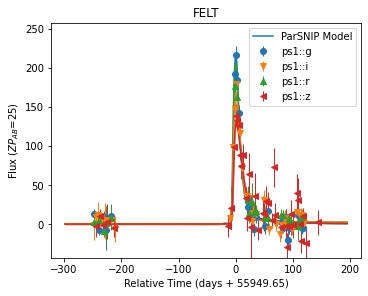

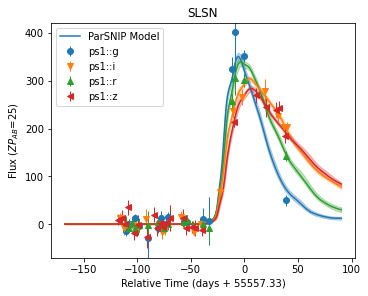

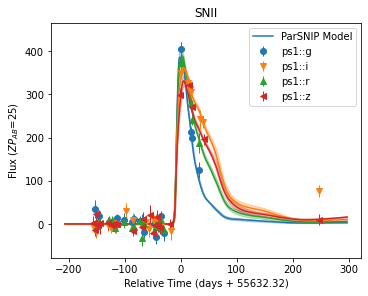

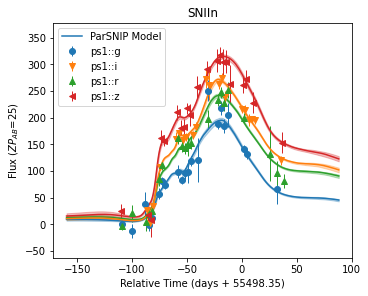

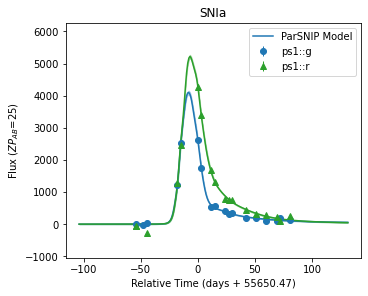

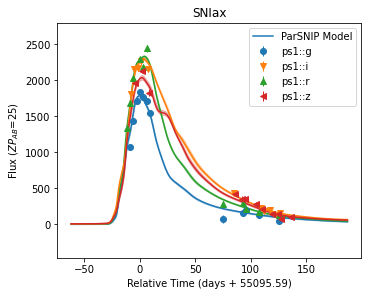

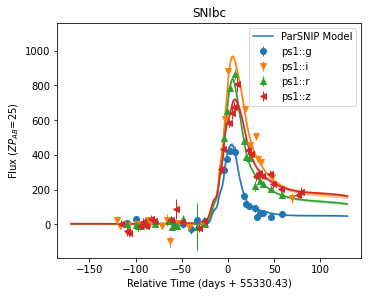

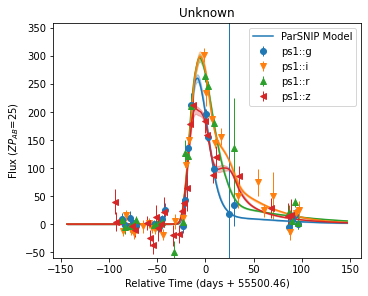

In [5]:
# Show randomly chosen examples of each type
obj_types = np.unique(ps1_dataset.meta['type'])

for obj_type in obj_types:
    # Find high signal-to-noise examples of that type
    match = np.where((ps1_dataset.meta['type'] == obj_type) & (ps1_predictions['total_s2n'] > 50))[0]

    # Choose one randomly
    idx = np.random.choice(match)

    parsnip.plot_light_curve(ps1_dataset.light_curves[idx], ps1_model)
    plt.title(obj_type)

## Validation set examples for the paper

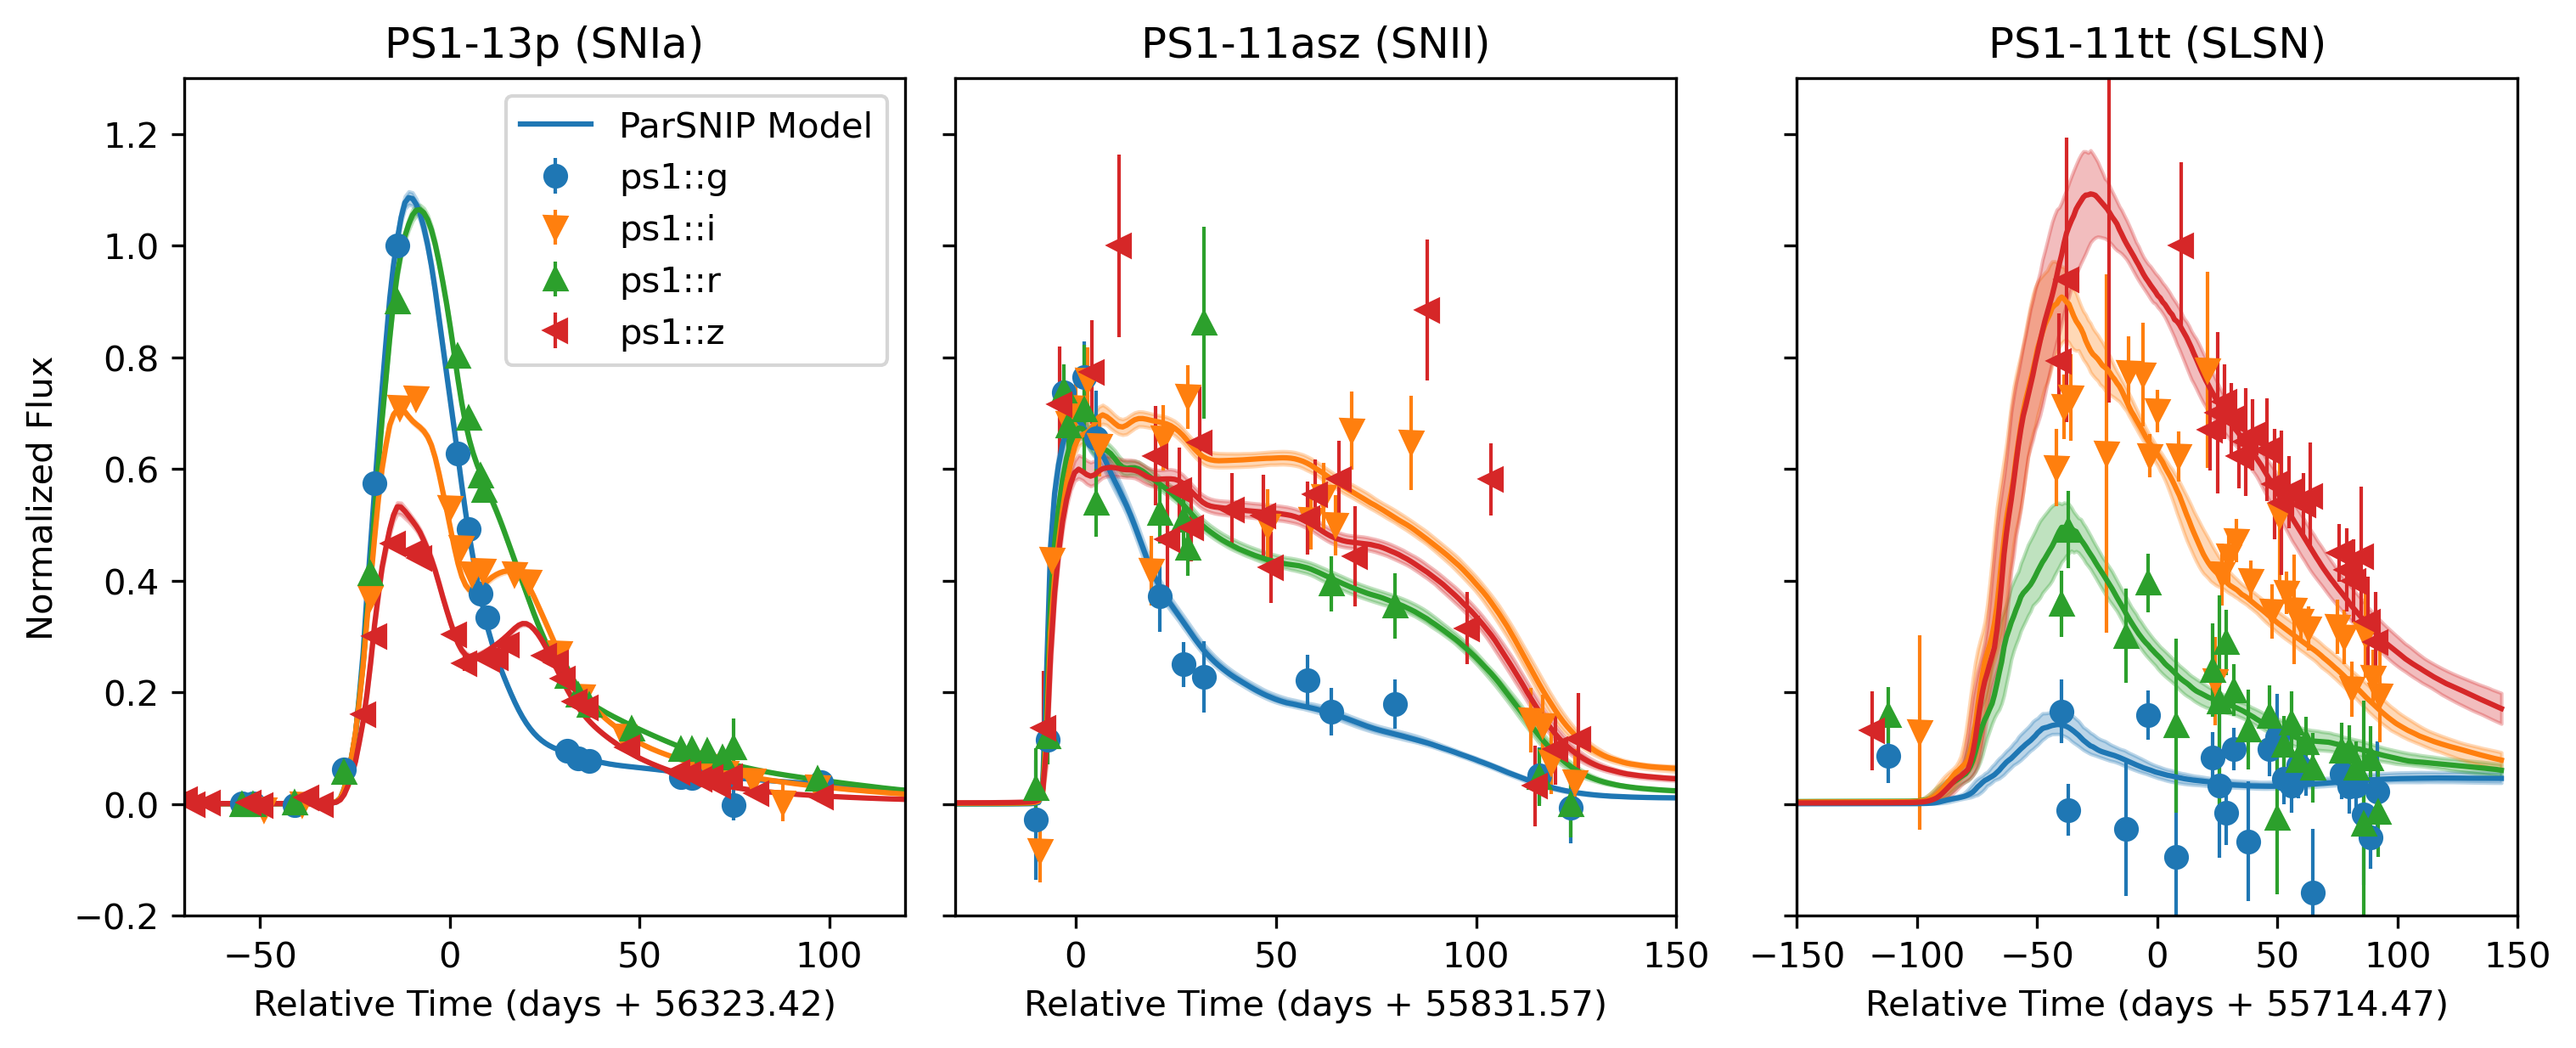

In [6]:
plot_idx = [211, 130, 92]

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True,
                         dpi=300, gridspec_kw={'wspace': 0.1}, constrained_layout=True)

for idx in range(3):
    ax = axes[idx]
    lc = ps1_test.light_curves[plot_idx[idx]]
    meta = lc.meta
    parsnip.plot_light_curve(lc, ps1_validation_model, ax=ax, normalize_flux=True)
    ax.set_title(f"{meta['object_name']} ({meta['type']})")
    if idx != 0:
        ax.set_ylabel(None)
        ax.get_legend().remove()

axes[0].set_ylim(-0.2, 1.3)

axes[0].legend(loc=1)
axes[0].set_xlim(-70, 120)
axes[1].set_xlim(-30, 150)
axes[2].set_xlim(-150, 150)

plt.savefig('./figures/model_examples.pdf')

# Probe the light curve reconstruction error

In [7]:
def probe_reconstruction(dataset, model, threshold=0.05):
    loader = model.get_data_loader(dataset)
    
    mag_err = []
    mag_diff = []
    
    for batch_lcs in loader:
        result = model.forward(batch_lcs, to_numpy=True, sample=False)
        
        obs_flux = result['obs_flux']
        obs_fluxerr = result['obs_fluxerr']
        model_flux = result['model_flux']

        # Cut out very low signal-to-noise measurements that will mess up the
        # conversion to magnitudes. We impose a magnitude cut later anyway, so this
        # won't impact the final result.
        cut = (obs_fluxerr > 0) & (obs_flux > 0) & (obs_fluxerr < obs_flux) & (model_flux > 0)
        batch_mag_err = parsnip.frac_to_mag(obs_fluxerr[cut] / obs_flux[cut])
        batch_mag_diff = -2.5*np.log10(obs_flux[cut] / model_flux[cut])
        
        mag_err.append(batch_mag_err)
        mag_diff.append(batch_mag_diff)

    mag_err = np.concatenate(mag_err)
    mag_diff = np.concatenate(mag_diff)

    cut = mag_err < threshold

    count = np.sum(cut)

    residual_error = parsnip.utils.nmad(mag_diff[cut])
    stat_error = np.sqrt(np.mean(mag_err[cut]**2))
    if residual_error > stat_error:
        model_error = np.sqrt(residual_error**2 - stat_error**2)
    else:
        model_error = 0.

    outliers02 = np.sum(np.abs(mag_diff[cut]) > 0.2)
    outliers05 = np.sum(np.abs(mag_diff[cut]) > 0.5)

    print(f'Number of observations: {count}')
    print(f'Residuals NMAD:         {residual_error:.4f} mag')
    print(f'Measurement error:      {stat_error:.4f} mag')
    print(f'Unexplained dispersion: {model_error:.4f} mag')
    print(f'Fraction < 0.2 mag:     {1 - outliers02 / count:.3f}')
    print(f'Fraction < 0.5 mag:     {1 - outliers05 / count:.3f}')

In [8]:
# Reconstruction error on the dataset that the PS1 model was trained on
probe_reconstruction(ps1_train, ps1_validation_model)

Number of observations: 5958
Residuals NMAD:         0.0399 mag
Measurement error:      0.0346 mag
Unexplained dispersion: 0.0200 mag
Fraction < 0.2 mag:     0.994
Fraction < 0.5 mag:     0.999


In [9]:
# Reconstruction error on the dataset that the PS1 model was not trained on
probe_reconstruction(ps1_test, ps1_validation_model)

Number of observations: 532
Residuals NMAD:         0.0685 mag
Measurement error:      0.0353 mag
Unexplained dispersion: 0.0588 mag
Fraction < 0.2 mag:     0.944
Fraction < 0.5 mag:     0.992


In [10]:
# Reconstruction error on the dataset that the PLAsTiCC model was trained on
probe_reconstruction(plasticc_train, plasticc_validation_model)

Number of observations: 3639
Residuals NMAD:         0.0477 mag
Measurement error:      0.0324 mag
Unexplained dispersion: 0.0351 mag
Fraction < 0.2 mag:     0.982
Fraction < 0.5 mag:     0.999


In [11]:
# Reconstruction error on the dataset that the PLAsTiCC model was not trained on
probe_reconstruction(plasticc_test, plasticc_validation_model)

Number of observations: 3849
Residuals NMAD:         0.0492 mag
Measurement error:      0.0322 mag
Unexplained dispersion: 0.0372 mag
Fraction < 0.2 mag:     0.972
Fraction < 0.5 mag:     0.997


# Look at the representations

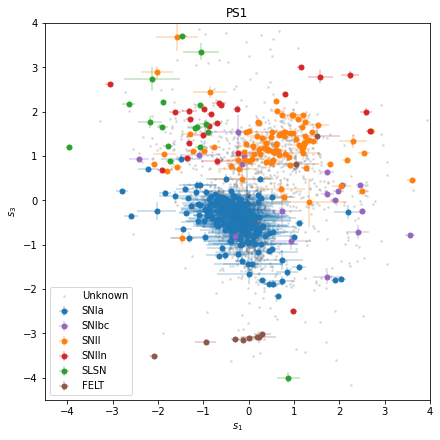

In [12]:
# PS1 representation
ps1_mask = ps1_predictions['supervised'] | (ps1_predictions['type'] == 'FELT')
ps1_plot_labels = ['SNIa', 'SNIbc', 'SNII', 'SNIIn', 'SLSN', 'FELT']

parsnip.plot_representation(ps1_predictions, ps1_plot_labels, ps1_mask, idx1=1, idx2=3, max_count=200)
plt.title('PS1')
plt.xlim(-4.5, 4)
plt.ylim(-4.5, 4)

plt.savefig('./figures/ps1_representation.pdf')

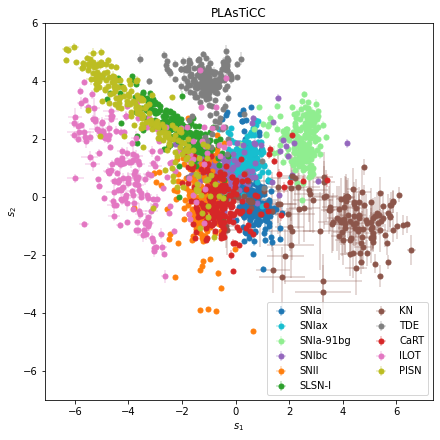

In [13]:
# PLAsTiCC representation
plasticc_plot_labels = ['SNIa', 'SNIax', 'SNIa-91bg', 'SNIbc', 'SNII', 'SLSN-I', 'KN', 'TDE', 'CaRT', 'ILOT', 'PISN']

use_pred = plasticc_predictions.copy()
use_pred.sort('total_s2n', reverse=True)
parsnip.plot_representation(use_pred, plasticc_plot_labels, idx1=1, idx2=2, max_count=200, legend_ncol=2)
plt.title('PLAsTiCC')
plt.ylim(-7, 6)

plt.savefig('./figures/plasticc_representation.pdf')

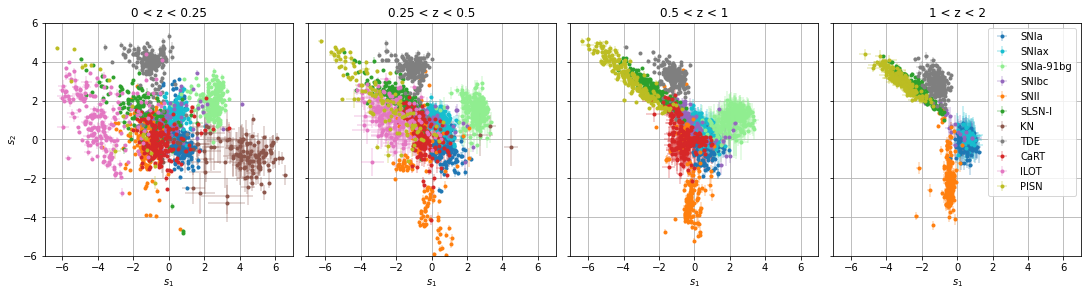

In [14]:
# PLAsTiCC at different redshifts
plasticc_plot_labels = ['SNIa', 'SNIax', 'SNIa-91bg', 'SNIbc', 'SNII', 'SLSN-I', 'KN', 'TDE', 'CaRT', 'ILOT', 'PISN']

show_individual = False

bins = (
    (0, 0.25),
    (0.25, 0.5),
    (0.5, 1),
    (1, 2),
)

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True,
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.02}, constrained_layout=True)

for idx in range(len(bins)):
    ax = axes[idx]
    min_z, max_z = bins[idx]

    mask = (plasticc_predictions['redshift'] > min_z) & (plasticc_predictions['redshift'] < max_z)
    use_pred = plasticc_predictions[mask]
    use_pred.sort('total_s2n', reverse=True)

    kwargs = {}

    if idx == 3:
        kwargs['legend_ncol'] = 1
    else:
        kwargs['show_legend'] = False

    # Common plot
    parsnip.plot_representation(use_pred, plasticc_plot_labels, idx1=1, idx2=2, max_count=200,
                                markersize=3, ax=ax, **kwargs)
    ax.set_title(f'{min_z} < z < {max_z}')
    ax.set_xlim(-7., 7.)
    ax.set_ylim(-6, 6)
    if idx > 0:
        ax.set_ylabel('')
    ax.grid()
    
    # Individual plots
    if show_individual:
        parsnip.plot_representation(use_pred, plasticc_plot_labels, idx1=1, idx2=2, max_count=200,
                                    legend_ncol=2)
        plt.title(f'{min_z} < z < {max_z}')
        plt.xlim(-7., 7.)
        plt.ylim(-6, 6)
        plt.grid()
        if max_z < 2.:
            plt.gca().get_legend().remove()
        plt.savefig(f'./figures/plasticc_representation_z_{int(min_z * 100):03d}_{int(max_z * 100):03d}.png', dpi=300)

fig.savefig('./figures/plasticc_representation_z.pdf')

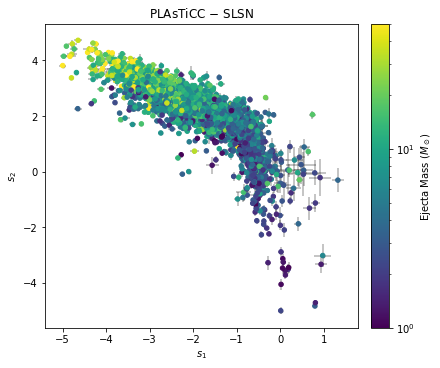

In [15]:
# Representation of PLAsTiCC SLSN
# This requires the PLAsTiCC model parameters which are available on Zenodo.
# https://zenodo.org/record/2539456
modelpar_data = Table.read('../data/plasticc_modelpar/plasticc_modelpar_095_SLSN-I.csv')
modelpar_data['object_id'] = [f'PLAsTiCC {i:09d}' for i in modelpar_data['object_id']]
mppred = join(plasticc_predictions, modelpar_data, keys='object_id')
mppred = mppred[mppred['total_s2n'] > 100]

plt.figure(figsize=(6, 5), constrained_layout=True)
plt.errorbar(mppred['s1'], mppred['s2'], xerr=mppred['s1_error'], yerr=mppred['s2_error'], fmt='.', c='k', alpha=0.3, zorder=-1)
plt.scatter(mppred['s1'], mppred['s2'], c=mppred['mej'], norm=colors.LogNorm(vmin=1, vmax=50), s=20)
plt.colorbar(label='Ejecta Mass ($M_\odot$)')
plt.xlabel('$s_1$')
plt.ylabel('$s_2$')
plt.title('PLAsTiCC $-$ SLSN')

plt.savefig('./figures/plasticc_slsn_ejecta_mass.pdf')

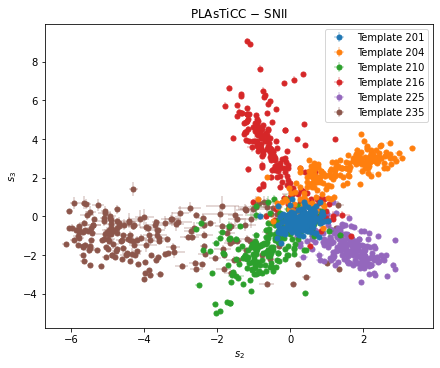

In [16]:
# Representation of PLAsTiCC SNII
# This requires the PLAsTiCC model parameters which are available on Zenodo.
# https://zenodo.org/record/2539456
modelpar_data = Table.read('../data/plasticc_modelpar/plasticc_modelpar_042_SNII-Templates.csv')
modelpar_data['object_id'] = [f'PLAsTiCC {i:09d}' for i in modelpar_data['object_id']]
mppred = join(plasticc_predictions, modelpar_data, keys='object_id')
mppred.sort('total_s2n', reverse=True)

plt.figure(figsize=(6, 5), constrained_layout=True)
for template in [201, 204, 210, 216, 225, 235]:
    cut_mppred = mppred[mppred['non1a_template_index'] == template]
    markers, caps, bars = plt.errorbar(cut_mppred['s2'][:200], cut_mppred['s3'][:200], xerr=cut_mppred['s2_error'][:200],
                                       yerr=cut_mppred['s3_error'][:200], label=f'Template {template}',
                                       fmt='o', markersize=5, zorder=-template)
    [bar.set_alpha(0.3) for bar in bars]
    
plt.xlabel('$s_2$')
plt.ylabel('$s_3$')
plt.title('PLAsTiCC $-$ SNII')
plt.legend()

plt.savefig('./figures/plasticc_snii_templates.pdf')

# Compare with SALT2

## SALT2 fits

In [17]:
# Fit SALT2 to all light curves.
mask = ps1_dataset.meta['supervised'] & (ps1_dataset.meta['type'] == 'SNIa')

results = []
fitted_models = []

for idx in tqdm(np.where(mask)[0]):
    lc = lcdata.to_sncosmo(ps1_dataset.light_curves[idx])

    salt_model = sncosmo.Model(source='salt2-extended')
    salt_model['z'] = lc.meta['redshift']
    salt_model['t0'] = lc.meta['parsnip_reference_time']

    result, fitted_model = sncosmo.fit_lc(lc, salt_model, ['t0', 'x0', 'x1', 'c'],
                                          bounds={'x1': (-10, 10), 'c': (-10, 10)})
    results.append(result)
    fitted_models.append(fitted_model)

results = Table(results)

salt_t0 = results['parameters'][:, 1]
salt_x0 = results['parameters'][:, 2]
salt_x1 = results['parameters'][:, 3]
salt_c = results['parameters'][:, 4]

salt_x1_err = []
salt_c_err = []

for cov in results['covariance']:
    if cov is None:
        salt_x1_err.append(1000.)
        salt_c_err.append(1000.)
    else:
        salt_x1_err.append(np.sqrt(cov[2, 2]))
        salt_c_err.append(np.sqrt(cov[3, 3]))

salt_x1_err = np.array(salt_x1_err)
salt_c_err = np.array(salt_c_err)

good_salt_mask = (
    results['success']
    & (salt_x1_err < 0.5)
    & (salt_c_err < 0.1)
    & (np.abs(salt_x1) < 5.)
    & (ps1_predictions['count_s2n_3_rise'][mask] >= 1)
)

100%|██████████| 404/404 [00:47<00:00,  8.44it/s]


## Compare with the SALT2 latent space

### SALT2 x1 comparison

Solve for the best linear combination of the ParSNIP latent variables that predicts the SALT2 x1 parameter

Best fit:               [ 0.49179656 -0.40948847 -0.14307349  1.54404103]
Pearson correlation:    0.8801122191906178
Difference RMS:         0.3402743740044042
Difference NMAD:        0.2352348220914946
Mean measurement error: 0.24567983311819422


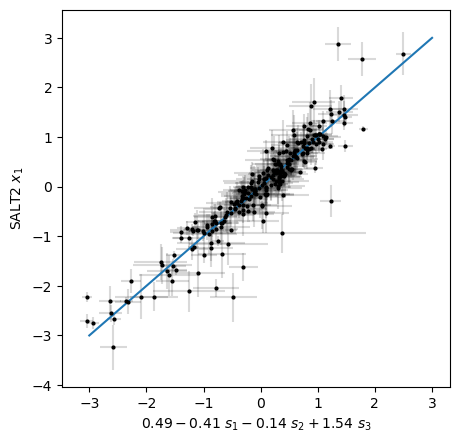

In [18]:
def find_best_rot(encoding, encoding_var, target):
    def apply_rot(coefs, x):
        return coefs @ x[1:] + x[0]

    def to_min(x):
        rot = apply_rot(encoding, x)
        return np.sum((rot - target)**2)

    res = minimize(to_min, np.zeros(encoding.shape[1] + 1))

    rot = apply_rot(encoding, res.x)
    rot_errs = np.sqrt(encoding_var @ (res.x[1:]**2))

    return res, rot, rot_errs

encoding_mu = np.array([ps1_predictions['s1'], ps1_predictions['s2'], ps1_predictions['s3']]).T
encoding_err = np.array([ps1_predictions['s1_error'], ps1_predictions['s2_error'], ps1_predictions['s3_error']]).T

res, rot, rot_errs = find_best_rot(
    encoding_mu[mask][good_salt_mask],
    encoding_err[mask][good_salt_mask]**2,
    salt_x1[good_salt_mask].data
)

plt.figure(figsize=(5, 5), dpi=100)
markers, caps, bars = plt.errorbar(rot, salt_x1[good_salt_mask], xerr=rot_errs, yerr=salt_x1_err[good_salt_mask], fmt='o', markersize=2, c='k')
[bar.set_alpha(0.15) for bar in bars]

print("Best fit:              ", res.x)
print("Pearson correlation:   ", np.corrcoef(rot, salt_x1[good_salt_mask])[0, 1]**2)
print("Difference RMS:        ", np.std(rot - salt_x1[good_salt_mask]))
print("Difference NMAD:       ", parsnip.utils.nmad(rot - salt_x1[good_salt_mask]))
print("Mean measurement error:", np.mean(salt_x1_err[good_salt_mask]))

x = res.x
plt.xlabel(f'${x[0]:.2f} {x[1]:+.2f}~s_1 {x[2]:+.2f}~s_2 {x[3]:+.2f}~s_3$')

# plt.xlabel('Rotation of Parsnip latent space')
plt.ylabel('SALT2 $x_1$')
plt.plot([-3, 3], [-3, 3])

plt.savefig('./figures/salt_x1_comparison.pdf')

### SALT2 c comparison

The "c" variables from SALT2 and the "color" variable from ParSNIP are both measures of the E(B-V) color, so they should agree. Note that their color zeropoints do not necessarily agree, so we solve for a difference in the zeropoint.

Explained Variance:     0.8932467047599536
Difference RMS:         0.043548859791341536
Difference NMAD:        0.03678588111128271
Mean measurement error: 0.01925953694004601


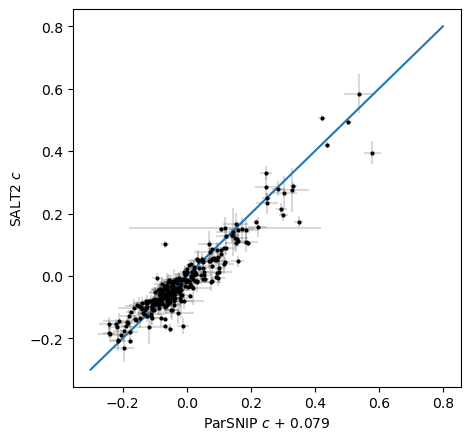

In [19]:
parsnip_c = ps1_predictions['color'][mask][good_salt_mask]
parsnip_c_err = ps1_predictions['color_error'][mask][good_salt_mask]

# The two c measurements can have different zeropoints. Estimate the resulting offset
# and add it to the parsnip color.
offset = np.median(salt_c[good_salt_mask]) - np.median(parsnip_c)
shift_parsnip_c = parsnip_c + offset

plt.figure(figsize=(5, 5), dpi=100)
markers, caps, bars = plt.errorbar(shift_parsnip_c, salt_c[good_salt_mask], xerr=parsnip_c_err, yerr=salt_c_err[good_salt_mask], fmt='o', markersize=2, c='k')
[bar.set_alpha(0.15) for bar in bars]

print("Explained Variance:    ", np.corrcoef(shift_parsnip_c, salt_c[good_salt_mask])[0, 1]**2)
print("Difference RMS:        ", np.std(shift_parsnip_c - salt_c[good_salt_mask]))
print("Difference NMAD:       ", parsnip.utils.nmad(shift_parsnip_c - salt_c[good_salt_mask]))
print("Mean measurement error:", np.mean(salt_c_err[good_salt_mask]))

plt.xlabel(f'ParSNIP $c$ + {offset:.2}')
plt.ylabel('SALT2 $c$')
plt.plot([-0.3, 0.8], [-0.3, 0.8])

plt.savefig('./figures/salt_c_comparison.pdf')

## SALT2 Hubble Diagram comparison

Here we look at the RMS of the Hubble residuals for SNe Ia assuming a fixed cosmology. We allow for linear corrections to the luminosity in terms of all of the latent variables and color.

In [20]:
# Solve for the linear combination of the latent variables that gives the best estimate of the luminosity
def find_rms(luminosity, coefficients):
    mask = np.ones_like(luminosity, dtype=bool)
    
    for i in range(10):
        def model(x):
            return x[0] + x[1:] @ coefficients

        def rms(x):
            return np.sqrt(np.mean((luminosity - model(x))[mask]**2))

        res = minimize(rms, np.zeros(len(coefficients) + 1))

        # Apply Chauvenet's criterion
        pred = model(res.x)
        residuals = luminosity - pred
        pulls = residuals / np.std(residuals[mask])
        criterion = 1. / 2 / np.sum(mask)
        valid = erfc(np.abs(pulls) / np.sqrt(2)) > criterion
        new_mask = mask & valid

        if np.all(mask == new_mask):
            print("Done!")
            print(res)
            break

        print(f"Rejecting {np.sum(mask) - np.sum(new_mask)} light curves., std={res.fun:.2f}")
        mask = new_mask

    print(f"RMS:  {np.std(residuals[mask]):.3f}")
    print(f"NMAD: {parsnip.utils.nmad(residuals[mask]):.3f}")

    return residuals, mask

In [21]:
# Estimate the residuals for SALT2
salt_residuals, salt_mask = find_rms(-2.5*np.log10(salt_x0[good_salt_mask]) - cosmo.distmod(ps1_predictions['redshift'][mask][good_salt_mask]).value,
                                     np.array([salt_x1[good_salt_mask], salt_c[good_salt_mask]]))

Rejecting 2 light curves., std=0.22
Rejecting 2 light curves., std=0.17
Rejecting 1 light curves., std=0.16
Done!
      fun: 0.15918559748765165
 hess_inv: array([[ 1.74003102e-01, -3.46578113e-03,  3.10409341e-02],
       [-3.46578113e-03,  1.84216940e-01,  4.10872346e-01],
       [ 3.10409341e-02,  4.10872346e-01,  1.59691006e+01]])
      jac: array([-4.21144068e-06,  1.49756670e-06,  7.61821866e-07])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 12
     njev: 22
   status: 0
  success: True
        x: array([-32.28097572,  -0.13391256,   3.05551924])
RMS:  0.159
NMAD: 0.140


In [22]:
# Estimate the residuals for ParSNIP
cut_pred = ps1_predictions[mask][good_salt_mask]
parsnip_residuals, parsnip_mask = find_rms(
    cut_pred['luminosity'],
    np.array([cut_pred['color'], cut_pred['s1'], cut_pred['s2'], cut_pred['s3']])
)

Rejecting 2 light curves., std=0.24
Rejecting 2 light curves., std=0.17
Rejecting 2 light curves., std=0.16
Rejecting 1 light curves., std=0.15
Done!
      fun: 0.1498401177162714
 hess_inv: array([[ 0.62970378,  1.09261076,  0.25316452, -0.12795564,  0.62516746],
       [ 1.09261076, 14.23198721, -1.06103102, -1.34251176,  0.80623188],
       [ 0.25316452, -1.06103102,  0.5187281 ,  0.09285729,  0.27644109],
       [-0.12795564, -1.34251176,  0.09285729,  4.35405721, -0.51536442],
       [ 0.62516746,  0.80623188,  0.27644109, -0.51536442,  1.01938309]])
      jac: array([ 7.32019544e-07, -2.01165676e-07, -3.74391675e-07,  7.07805157e-08,
        5.14090061e-07])
  message: 'Optimization terminated successfully.'
     nfev: 204
      nit: 24
     njev: 34
   status: 0
  success: True
        x: array([-18.03655126,  -1.31579001,   0.01874418,   0.01977051,
        -0.08389709])
RMS:  0.150
NMAD: 0.127


In [23]:
# Use bootstrapping to estimate uncertainties on the RMS/NMAD
def bootstrap_rms(data):
    all_rms = []
    for i in range(1000):
        all_rms.append(np.std(data[np.random.choice(len(data), len(data))]))
    
    return np.std(data), np.std(all_rms), np.array(all_rms)

def bootstrap_nmad(data):
    all_nmad = []
    for i in range(1000):
        all_nmad.append(parsnip.utils.nmad(data[np.random.choice(len(data), len(data))]))

    return parsnip.utils.nmad(data), np.std(all_nmad), np.array(all_nmad)

combo_mask = parsnip_mask & salt_mask
salt_rms, salt_rmserr, all_salt_rms = bootstrap_rms(salt_residuals[combo_mask])
parsnip_rms, parsnip_rmserr, all_parsnip_rms = bootstrap_rms(parsnip_residuals[combo_mask])
salt_nmad, salt_nmaderr, all_salt_nmad = bootstrap_nmad(salt_residuals[combo_mask])
parsnip_nmad, parsnip_nmaderr, all_parsnip_nmad = bootstrap_nmad(parsnip_residuals[combo_mask])

print(f"Total SNe~Ia:    {len(combo_mask)}")
print(f"Rejected SNe~Ia: {np.sum(~combo_mask)}")
print(f"SALT2:")
print(f"    RMS:  {salt_rms:.3f} +/- {salt_rmserr:.3f} mag")
print(f"    NMAD: {salt_nmad:.3f} +/- {salt_nmaderr:.3f} mag")
print(f"ParSNIP:")
print(f"    RMS:  {parsnip_rms:.3f} +/- {parsnip_rmserr:.3f} mag")
print(f"    NMAD: {parsnip_nmad:.3f} +/- {parsnip_nmaderr:.3f} mag")

Total SNe~Ia:    265
Rejected SNe~Ia: 8
SALT2:
    RMS:  0.155 +/- 0.008 mag
    NMAD: 0.139 +/- 0.012 mag
ParSNIP:
    RMS:  0.150 +/- 0.007 mag
    NMAD: 0.126 +/- 0.010 mag


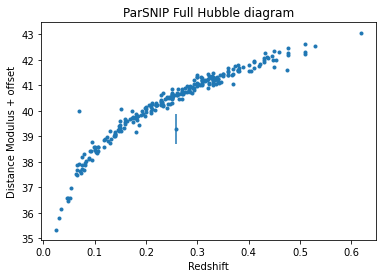

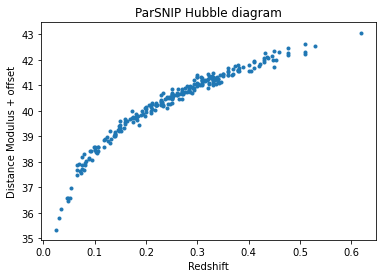

In [24]:
# Show the ParSNIP Hubble diagram, with and without Chauvenet's criterion applied.
plt.figure()
f = ps1_predictions[mask][good_salt_mask]
plt.errorbar(f['redshift'], parsnip_residuals + cosmo.distmod(f['redshift']).value, f['luminosity_error'], fmt='.')
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus + offset')
plt.title('ParSNIP Full Hubble diagram')

plt.figure()
f = ps1_predictions[mask][good_salt_mask][combo_mask]
plt.errorbar(f['redshift'], parsnip_residuals[combo_mask] + cosmo.distmod(f['redshift']).value,
             f['luminosity_error'], fmt='.')
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus + offset')
plt.title('ParSNIP Hubble diagram');

## SALT2 reconstruction error

Probe the reduced chi-squares for both the SALT2 and ParSNIP models.

In [25]:
def compare_salt_residuals(dataset, model):
    # Cut to only confirmed SNe Ia
    dataset = dataset[(dataset.meta['type'] == 'SNIa') & (dataset.meta['supervised'])]

    loader = model.get_data_loader(dataset)

    mag_err = []
    parsnip_mag_diff = []
    salt_mag_diff = []
    
    parsnip_chisq = []
    salt_chisq = []

    for batch_lcs in loader:
        # Run the data through the model.
        result = model.forward(batch_lcs, sample=False, to_numpy=True)

        for idx in range(len(result['amplitude'])):
            mask = result['obs_fluxerr'][idx] > 0

            time = result['time'][idx][mask]
            flux = result['obs_flux'][idx][mask]
            fluxerr = result['obs_fluxerr'][idx][mask]
            band = np.array(model.settings['bands'])[result['band_indices'][idx][mask]]
            parsnip_flux = result['model_flux'][idx][mask]

            # Fit SALT2 to the exact same data.
            lc = Table({
                'time': time,
                'band': band,
                'flux': flux,
                'fluxerr': fluxerr,
            })
            lc['zp'] = 25.
            lc['zpsys'] = 'ab'

            salt_model = sncosmo.Model(source='salt2-extended')
            salt_model['z'] = batch_lcs[idx].meta['redshift']
            salt_model['t0'] = np.argmax(lc['flux'] / lc['fluxerr'])

            salt_result, fitted_model = sncosmo.fit_lc(lc, salt_model, ['t0', 'x0', 'x1', 'c'],
                                                       bounds={'x1': (-10, 10), 'c': (-10, 10)})

            try:
                salt_flux = fitted_model.bandflux(band, time, zp=25., zpsys='ab')
            except:
                continue

            # Restrict to valid observations
            range_mask = (
                (fluxerr > 0) & (flux > 0) & (fluxerr < flux)
                & (time > fitted_model.mintime()) & (time < fitted_model.maxtime())
            )
            if np.sum(range_mask) < 7:
                # Not enough degrees of freedom to actually compute a chisquare
                continue

            salt_pulls = ((flux - salt_flux)**2 / fluxerr**2)[range_mask]
            parsnip_pulls = ((flux - parsnip_flux)**2 / fluxerr**2)[range_mask]
            parsnip_chisq.append(np.sum(parsnip_pulls) / (np.sum(range_mask) - 6))
            salt_chisq.append(np.sum(salt_pulls) / (np.sum(range_mask) - 4))
    
        break

    parsnip_chisq = np.array(parsnip_chisq)
    salt_chisq = np.array(salt_chisq)

    return parsnip_chisq, salt_chisq

parsnip_chisq_train, salt_chisq_train = compare_salt_residuals(ps1_train, ps1_validation_model)
parsnip_chisq_test, salt_chisq_test = compare_salt_residuals(ps1_test, ps1_validation_model)

In [26]:
print("Median chisqs for SN Ia light curve fits")
print(f"    ParSNIP train: {np.median(parsnip_chisq_train):.3f}")
print(f"    ParSNIP test:  {np.median(parsnip_chisq_test):.3f}")
print(f"    SALT2 train:   {np.median(salt_chisq_train):.3f}")
print(f"    SALT2 test:    {np.median(salt_chisq_test):.3f}")

Median chisqs for SN Ia light curve fits
    ParSNIP train: 1.424
    ParSNIP test:  1.679
    SALT2 train:   1.402
    SALT2 test:    1.218


Text(0, 0.5, 'Count')

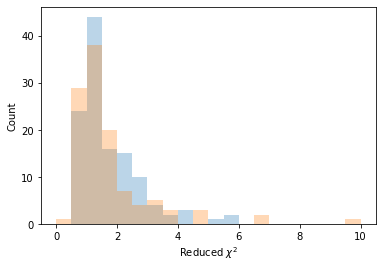

In [27]:
# Plot a histogram of the reduced chi-squares
plt.figure()
plt.hist(parsnip_chisq_train, 20, (0, 10), alpha=0.3)
plt.hist(salt_chisq_train, 20, (0, 10), alpha=0.3)
plt.xlabel('Reduced $\chi^2$')
plt.ylabel('Count')

# Test shifting the input redshifts

In [28]:
# Generate a new catalog with the redshifts all shifted
ref_catalog = ps1_model.predict_dataset(ps1_dataset)

shift = 0.05

shift_lcs = []
for lc in ps1_dataset.light_curves:
    lc = deepcopy(lc)
    lc.meta['redshift'] = np.clip(lc.meta['redshift'] + np.random.normal(scale=shift), 0.0001, None)
    shift_lcs.append(lc)

shift_dataset = lcdata.from_light_curves(shift_lcs)
shift_catalog = ps1_model.predict_dataset(shift_dataset)

for i in range(3):
    print(f'RMS of s{i+1}: ', np.sqrt(np.mean((ref_catalog[f's{i+1}'] - shift_catalog[f's{i+1}'])**2)))
print(f'RMS of color: ', np.sqrt(np.mean((ref_catalog[f'color'] - shift_catalog[f'color'])**2)))

RMS of s1:  0.20178519
RMS of s2:  0.09787414
RMS of s3:  0.11836966
RMS of color:  0.05938458
